# Aula 12 - Background Segmentation

Referências: 
    1. Szeilisk - Cap 4
    1. Artigo Kim et a. - Real-time foreground–background segmentation using codebook model


In [1]:
import pickle
import cv2 as cv
import numpy as np
from random import shuffle
from math import sqrt
import os, time
import matplotlib.pyplot as plt

In [2]:
class Codeword:
    def __init__(self, r, g, b, min_brightness, max_brightness, freq, mnrl, first_access, last_access):
        self.rgb = (r,g,b)
        self.aux = (
            min_brightness,
            max_brightness,
            freq,
            mnrl,
            first_access,
            last_access
        )

def colordist(xt, vi):
    r, g, b = xt
    ri, gi, bi = vi

    xt_2 = (r**2) + (g**2) + (b**2)
    vi_2 = (ri**2) + (gi**2) + (bi**2)
    xt_vi_2 = ((r*ri) + (g*gi) + (b*bi))**2

    if vi_2 == 0:
        p_2 = 0
    else:
        p_2 = xt_vi_2/vi_2

    return sqrt(abs(xt_2 - p_2))

def brightness(bright_norm, bright_tuple, alpha=0.4, beta=1.1):
    bright_low, bright_high = bright_tuple
    if (alpha*bright_high <= bright_norm <= min(bright_high*beta, bright_low/alpha)):
        return True
    else:
        return False

def find_codeword(x, bright, codebook, e=26):
    if len(codebook) == 0:
        return False
    for i in range(len(codebook)):
        matched = codebook[i]
        I_min, I_max, f, mnrl, p, q = matched.aux
        if (colordist(x, matched.rgb) <= e) and (brightness(bright, (I_min, I_max))):
            return matched
    return False

# Treinamento do Codebook

In [3]:
def train():
    # directory = "./Crowd_PETS09/S0/Background/View_001/Time_13-06/"
    # images = os.listdir(directory)
    # images = images[25:]
    # shuffle(images[25:])
    # images = images[0:50]
    img = cv.imread(directory + images[0], 1)
    h, w, d = img.shape

    N = len(images) - (len(images)/2)
    L = 0
    codebook = []
    for i in range(h):
        codebook.append([])
        for j in range(w):
            codebook[i].append([])

    for t in range(1, N): #For each image	
        print("Iniciada imagem:", t)
        start = time.time()
        bg = cv.imread(directory + images[t], 1)
        bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
        bg = bg.astype(float)
        height, width, dimensions = bg.shape
        for i in range(height):
            for j in range(width):
                x = bg[i][j]
                r = x[0]
                g = x[1]
                b = x[2]
                brightness = sqrt((r**2) + (g**2) + (b**2))

                #Search codeword
                found = find_codeword(x, brightness, codebook[i][j], i)
                
                #If codeword not found
                if (found == False):
                    #Create another codeword
                    L = L + 1
                    codeword = Codeword(r, g, b, brightness, brightness, 1, t-1, t, t)
                    codebook[i][j].append(codeword)
                    
                #Codeword found
                else:
                    #Get matched codeword
                    matched = found
                    rm, gm, bm = matched.rgb
                    min_Im, max_Im, fm, MNRLm, pm, qm = matched.aux
                    
                    #Update matched codeword RGB
                    new_r = (((fm*rm) + r) / (fm + 1))
                    new_g = (((fm*gm) + g) / (fm + 1))
                    new_b = (((fm*bm) + b) / (fm + 1))
                    matched.rgb = (new_r, new_g, new_b)

                    #Update matched codeword AUX
                    matched.aux = (
                        min(brightness, min_Im),
                        max(brightness, max_Im),
                        fm + 1,
                        max(MNRLm, t-qm),
                        pm,
                        t)
        print("Imagem", t, "lida em " , time.time() - start)

        for k in range(len(codebook)):
            for l in range(len(codebook[i])):
                for codeword in codebook[k][l]:
                    min_bright, max_bright, freq, MNRL, first_access, last_access = codeword.aux
                    codeword.aux = (min_bright,
                    max_bright,
                    freq, 
                    max(MNRL, (N - last_access + first_access - 1)),
                    first_access,
                    last_access)
    return codebook

In [4]:
# Descomentar caso precise treinar!
# img_codebook = train()
# pickle.dump(img_codebook, open("training.p", "wb"))

# "Background Subraction"

In [5]:
def bg_subtraction(directory):
    images = os.listdir(directory)
    images = images[153:] #Alterar aqui caso queira imagens diferentes
    N = 3 #Alterar aqui caso queira mais imagens
    L = 0
    codebook = pickle.load(open("training.p", "rb"))
    for t in range(1, N): #For each image
        image = cv.imread(directory + images[t], 1)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = image.astype(float)
        copy = image.copy()
        height, width, dimensions = image.shape
        for i in range(height):
            for j in range(width):
                x = image[i][j]
                pixel_codebook = codebook[i][j]
                r = x[0]
                g = x[1]
                b = x[2]
                brightness = sqrt((r**2) + (g**2) + (b**2))

                #Search codeword
                found = find_codeword(x, brightness, pixel_codebook)

                if found == False:
                    #Background Subtraction
                    copy[i][j] = [255, 255, 255]
                else:
                    #Get matched codeword
                    matched = found
                    rm, gm, bm = matched.rgb
                    min_Im, max_Im, fm, MNRLm, pm, qm = matched.aux

                    #Update matched codeword RGB
                    new_r = (((fm*rm) + r) / (fm + 1))
                    new_g = (((fm*gm) + g) / (fm + 1))
                    new_b = (((fm*bm) + b) / (fm + 1))
                    matched.rgb = (new_r, new_g, new_b)
                    
                    #Update matched codeword AUX
                    matched.aux = (
                        min(brightness, min_Im),
                        max(brightness, max_Im),
                        fm + 1,
                        max(MNRLm, t-qm),
                        pm,
                        t)
                    
                    #Background Subtraction
                    copy[i][j] = [0, 0, 0]
                    
        count_copy = copy.copy()
        
        #Cleaning image for counting
        kernel = np.ones((7,7), np.uint8)
        count_copy = cv.erode(count_copy, kernel, iterations=1)
        count_copy = cv.dilate(count_copy, kernel, iterations=2)
        count_copy = cv.blur(count_copy, (7,7))
        
        #Parameters for OpenCV's Simple Blob Detector
        #https://docs.opencv.org/3.4/d8/da7/structcv_1_1SimpleBlobDetector_1_1Params.html
        params = cv.SimpleBlobDetector_Params()
        params.minArea = 300
        params.filterByConvexity = False
        params.filterByColor = False
        params.filterByCircularity = False
        params.filterByInertia = False
        params.filterByArea = True
        detector = cv.SimpleBlobDetector_create(params)
        
        keypoints = detector.detect(255-np.uint8(count_copy))
        im_with_keypoints = cv.drawKeypoints(np.uint8(image), keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        print("Contagem:", len(keypoints), "elemento(s)")
        
        plt.imshow(np.uint8(copy))
        plt.show()
        plt.imshow(np.uint8(image))
        plt.show()

Contagem: 2 elemento(s)


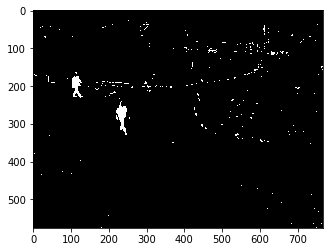

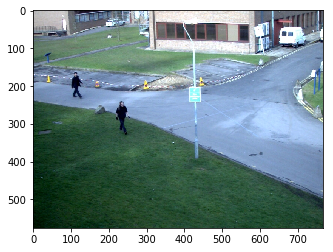

Contagem: 0 elemento(s)


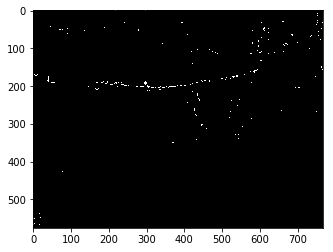

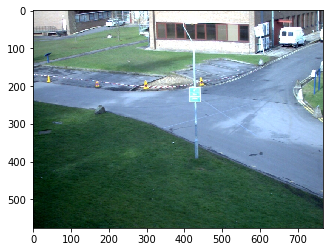

In [6]:
subtraction_directory = "./Crowd_PETS09/S0/Background/View_001/Time_13-19/"
bg_subtraction(subtraction_directory)